### Tasks to Complete

1. Review the descriptive statistics of the sample:

   - Characteristics such as year of training, age, gender, race, and prior education.
   - Mean scores of PPOS and PPOS subscales.

2. Perform comparisons of PPOS and subscales:

   - By year of training.
   - By gender (Male/Female).
   - By prior education (e.g., CEGEP, Bachelors, Graduate).
   - By intended specialization:
     - Primary vs. non-primary care.
     - Surgical vs. non-surgical.

3. Clean and preprocess the dataset:

   - Ensure all columns are renamed appropriately using the `column_rename` dictionary.
   - Drop unnecessary columns (`gender_other`, `race_other`).

4. Explore and visualize the data:

   - Generate plots to visualize the distribution of key variables (e.g., age, PPOS scores).
   - Create comparison plots for PPOS and subscales based on the specified categories.

5. Document findings and insights:
   - Summarize the key characteristics of the sample.
   - Highlight significant differences in PPOS and subscales across the specified categories.


In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
from unidecode import unidecode
from IPython.core.display import display, HTML

# plt.style.use('dark_background')
sns.set_theme(style="darkgrid", palette="bright")


display(
    HTML(
        """
<style>
.scroll-table {
    display: block;
    overflow-x: auto;
    white-space: nowrap;
}
</style>
"""
    )
)

/var/folders/sj/0xqydhcs0ts9625x6bv4hzmr0000gn/T/ipykernel_36482/1455801.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [2]:
column_rename = {
    "Record ID": "record_id",
    "Timepoint": "timepoint",
    "PPOS": "ppos",
    "PPOS-S": "ppos_s",
    "PPOS-C": "ppos_c",
    "Age:": "age",
    "Gender Identity": "gender",
    "Other: Specify": "gender_other",
    "How proficient are you in French?": "french_proficiency",
    "How proficient are you in English?": "english_proficiency",
    "Do you speak any other languages? Please specify your proficiency (Fluent, Moderate, Basic). Please answer in format: [Language, Proficiency] for all languages.    ": "other_languages",
    "Please specify if other level of training": "other_training",
    "Please list all previous education you have completed (e.g., CEGEP, BSc, MSc, PHD, other professional certification). Please answer in format [degree, year of completion]": "prior_education",
    "Site of study": "site_of_study",
    "Do you have an intended specialization (including Family Medicine)?": "intended_specialization",
    "What is your intended specialization?": "specialty",
    # Cultural identity columns
    "Other (Please specify):": "race_other",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=Black/African Canadian)": "cultural_black",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=East Asian (e.g., Chinese, Japanese, Korean))": "cultural_east_asian",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=Indigenous (First Nations, Métis, Inuit))": "cultural_indigenous",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=Middle Eastern/North African (e.g., Arab, Persian))": "cultural_middle_eastern",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=Latin American (e.g., Mexican, Brazilian, Coloumbian))": "cultural_latin_american",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=South Asian (e.g., Indian, Bangladeshi, Sri Lankan))": "cultural_south_asian",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=South East Asian (e.g. Filipino, Vietnamese, Thai))": "cultural_southeast_asian",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=White/Caucasian)": "cultural_white",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=Other (please specify))": "cultural_other",
}

df = pd.read_excel("MSHumanism_CleanQuantData_250625_AC.xlsx", sheet_name="Full Data")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")].rename(columns=column_rename)
df['prior_education'] = df["prior_education"].apply(unidecode)
df.head()

,record_id,timepoint,ppos,ppos_s,ppos_c,age,gender,gender_other,cultural_black,cultural_east_asian,...,cultural_other,race_other,french_proficiency,english_proficiency,other_languages,other_training,prior_education,site_of_study,intended_specialization,specialty
0,1,M2 (TCP),88,40,48,21,Female,NaN,Unchecked,Unchecked,...,Unchecked,NaN,Fluent,Fluent,"Spanish (moderate), Arab (moderate)",NaN,"CEGEP, 2022",Montreal,Yes,Internal medicine
1,2,M4,75,29,46,42,Female,NaN,Unchecked,Unchecked,...,Unchecked,NaN,Fluent,Fluent,"Hindi, Punjabi, Urdu",NaN,Graduate studies in Experimental Medicine,Montreal,No,NaN
2,3,M3,76,38,38,30,Male,NaN,Unchecked,Unchecked,...,Unchecked,NaN,Moderate,Fluent,"Arabic, proficient",NaN,"Bsc, jd, llm",Montreal,Yes,Dermatology
3,5,M2 (TCP),76,42,34,25,Male,NaN,Unchecked,Unchecked,...,Unchecked,NaN,Moderate,Fluent,none,NaN,"CEGEP, Bsc, Msc",Montreal,Yes,internal medicine - maybe medical oncology
4,7,M3,61,33,28,27,Male,NaN,Checked,Unchecked,...,Unchecked,NaN,Fluent,Fluent,Basic Japanese,NaN,BSc Human Kinetics 2020 BSc Translational and...,Montreal,Yes,Anesthesia


In [3]:
# dropping columns with 0 or non-essential data
df = df.drop(columns=["gender_other", "race_other"])

Cannot make race into one column since some people have 2+ selected


In [4]:
def checked(row):
    return row.lower() == "checked"


checked_cols = [
    "cultural_black",
    "cultural_east_asian",
    "cultural_indigenous",
    "cultural_middle_eastern",
    "cultural_latin_american",
    "cultural_south_asian",
    "cultural_southeast_asian",
    "cultural_white",
    "cultural_other",
]
if df[checked_cols[0]].dtype != "bool":
    df[checked_cols] = df[checked_cols].map(checked)

In [5]:
# make degree columns

df['has_dec'] = df['prior_education'].str.lower().str.replace(".","").str.contains('dec|cegep|bac|cegep')
df['has_bsc'] = df['prior_education'].str.lower().str.replace(".","").str.contains('bsc|undergrad|b.asc|b.sc|bs|ba|bachelor|bkin|beng|b')
df['has_msc'] = df['prior_education'].str.lower().str.replace(".","").str.contains('msc|graduate|ma')
df['has_doc'] = df['prior_education'].str.lower().str.replace(".","").str.contains('phd|pharmd|pharm.d|llm')


#df[['prior_education', 'has_dec', 'has_bsc', 'has_msc', 'has_doc']].sort_values(by="has_doc")
# Filter rows where any of the 'has_' columns are False and print them
#edu_cols = [col for col in df.columns if col.startswith('has_')]
# df.loc[~df[has_columns].any(axis=1), ['prior_education'] + has_columns]

In [6]:
df.columns

Index(['record_id', 'timepoint', 'ppos', 'ppos_s', 'ppos_c', 'age', 'gender',
       'cultural_black', 'cultural_east_asian', 'cultural_indigenous',
       'cultural_middle_eastern', 'cultural_latin_american',
       'cultural_south_asian', 'cultural_southeast_asian', 'cultural_white',
       'cultural_other', 'french_proficiency', 'english_proficiency',
       'other_languages', 'other_training', 'prior_education', 'site_of_study',
       'intended_specialization', 'specialty', 'has_dec', 'has_bsc', 'has_msc',
       'has_doc'],
      dtype='object')

In [7]:
def get_highest_degree(row):
    if row['has_doc']:
        return 'Doctorate'
    elif row['has_msc']:
        return 'Masters'
    elif row['has_bsc']:
        return 'Bachelors'
    elif row['has_dec']:
        return 'DEC/CEGEP'
    else:
        return 'None'

df['highest_degree'] = df.apply(get_highest_degree, axis=1)

In [8]:
def clean_timepoint(s):
    s = s.upper().strip()
    matches = re.match(r"M\d+", s)
    return matches.group() if matches is not None else None


df["timepoint"] = df["timepoint"].map(clean_timepoint)

In [ ]:
df_speciality = pd.read_excel('MSHumanism_CleanQuantData_250625_AC.xlsx', sheet_name='specialty')
df_speciality.columns = df_speciality.columns.str.lower().str.replace(" ", "_")
df_speciality = df_speciality.loc[:, ['record_id','primary_care', 'non_primary_care', 'surgical', 'non_surgical']]
df_speciality

if "non_surgical" not in df.columns: 
    df = df.join(df_speciality.set_index('record_id'), on='record_id', how='left')


# NOTE: 'primary_care' and 'non_primary_care' are independent boolean columns.
# A row can be True for both, False for both, or True for only one.
# Always analyze and plot them independently.
speciality_cols = ['primary_care', 'non_primary_care', 'surgical', 'non_surgical']
# new way since lambda does not work for integer to bool conversion, 1 is always true
df[speciality_cols] = df[speciality_cols] == 1


Part 1: Review the descriptive statistics:

- Year of training
- Age
- Gender
- Race
- Prior education
- Mean scores of PPOS and subscales


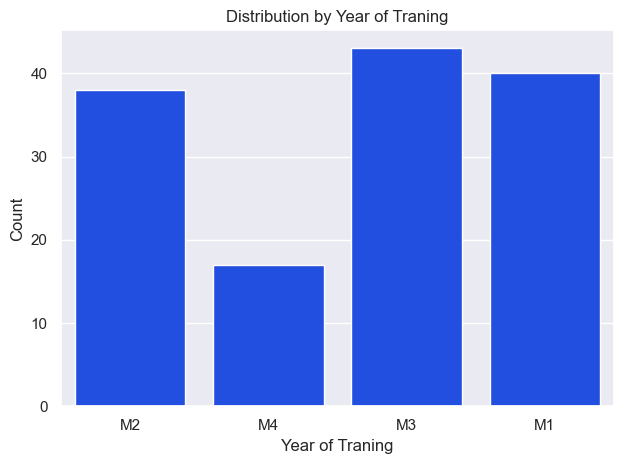

timepoint
M3    43
M1    40
M2    38
M4    17
Name: count, dtype: int64

In [10]:
sns.countplot(df,x='timepoint')
plt.title("Distribution by Year of Traning")
plt.xlabel("Year of Traning")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

df['timepoint'].value_counts()

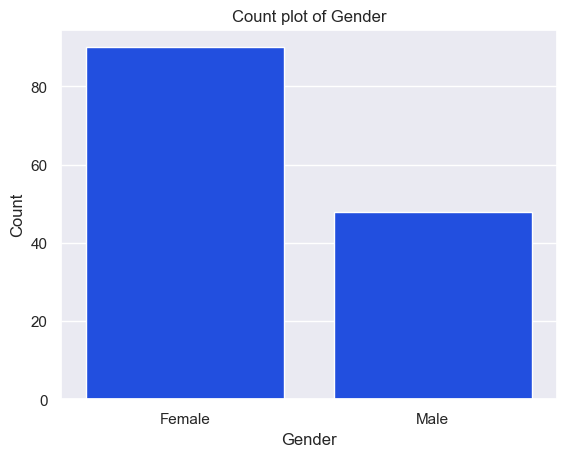

gender
Female    90
Male      48
Name: count, dtype: int64

In [11]:
ax = sns.countplot(df, x="gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Count plot of Gender")
# for p in ax.patches:
#     ax.annotate(
#         int(p.get_height()),
#         (p.get_x() + p.get_width() / 2, p.get_height()),
#         ha="center",
#         va="bottom",
#         fontsize=12,
#     )
plt.show()

df['gender'].value_counts()

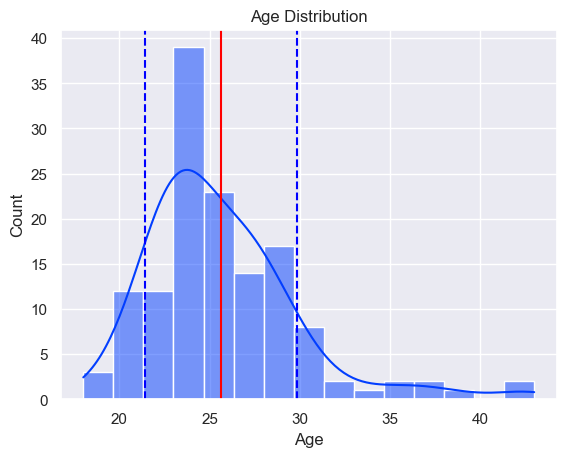

count    138.000000
mean      25.637681
std        4.197570
min       18.000000
max       43.000000
Name: age, dtype: float64

In [12]:
drop_desc = ["25%", "50%", "75%"]


age_mean = df['age'].mean()
age_std = df['age'].std()
sns.histplot(df['age'], bins=15, kde=True)
plt.title('Age Distribution')
plt.axvline(age_mean, c='red')
plt.axvline(age_mean - age_std, c = "blue" , linestyle="--")
plt.axvline(age_mean + age_std, c = "blue" , linestyle="--")
plt.xlabel('Age')
plt.show()

df["age"].describe().drop(drop_desc)

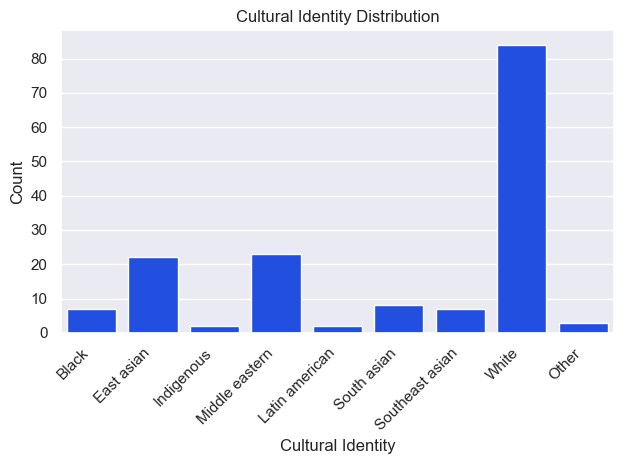

,Cultural Identity,Count
7,White,84
3,Middle eastern,23
1,East asian,22
5,South asian,8
0,Black,7
6,Southeast asian,7
8,Other,3
2,Indigenous,2
4,Latin american,2


In [13]:
race_cols = [col for col in df.columns if col.startswith('cultural_')]

cultural_counts = df[race_cols].sum().reset_index()
cultural_counts.columns = ['Cultural Identity', 'Count']

cultural_counts['Cultural Identity'] = cultural_counts['Cultural Identity'].str.replace("cultural_","").str.replace('_', " ").str.capitalize()
sns.barplot(data=cultural_counts, x='Cultural Identity', y='Count')
plt.title('Cultural Identity Distribution')
plt.ylabel('Count')
plt.xlabel('Cultural Identity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

cultural_counts.sort_values(by="Count", ascending=False)

In [14]:
edu_cols = [col for col in df.columns if col.startswith('has_')]
edu_counts = df[edu_cols].sum().reset_index()
edu_counts.columns = ['Education', 'Count']
edu_counts['Education'] = edu_counts["Education"].str.upper().str.split("_").str[1]



# sns.barplot(edu_counts, x='Education', y='Count')
# plt.title("Count of previous degrees")
# plt.xlabel("Degree")
# plt.tight_layout()
# plt.show()

# edu_counts

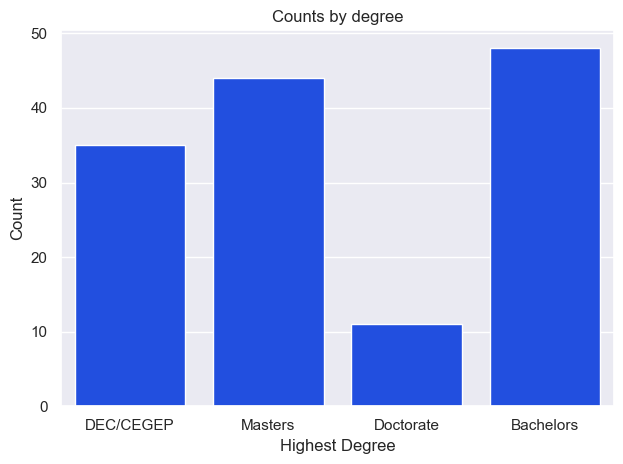

highest_degree
Bachelors    48
Masters      44
DEC/CEGEP    35
Doctorate    11
Name: count, dtype: int64

In [15]:
sns.countplot(df, x='highest_degree')
plt.title("Counts by degree")
plt.xlabel("Highest Degree")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

df['highest_degree'].value_counts()



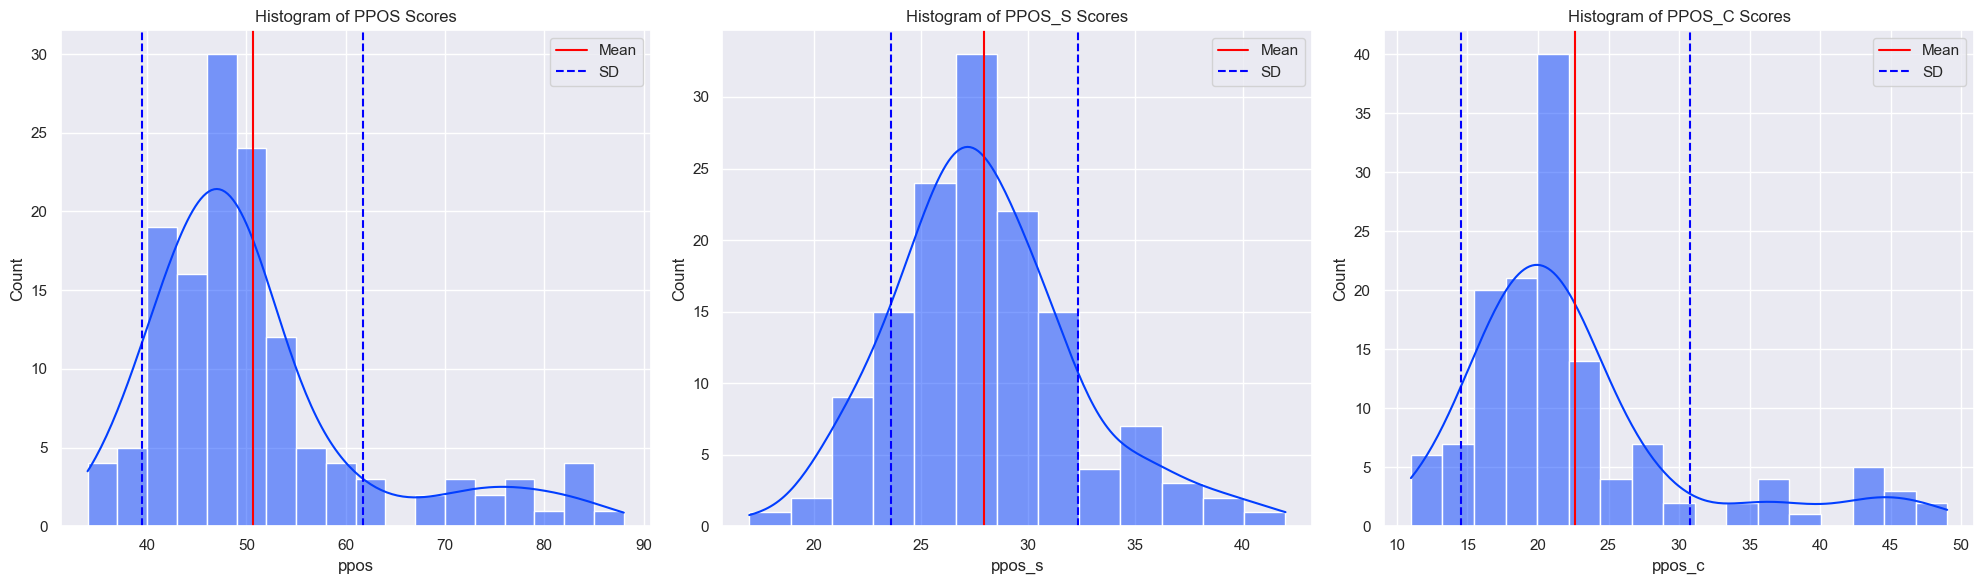

In [16]:
# df['gender'].value_counts()
# df[['ppos', 'ppos_s', 'ppos_c']].describe().loc[['mean', 'std']]

score_cols = ["ppos", "ppos_s", "ppos_c"]
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, col in zip(axes, score_cols):
    sns.histplot(df, x=col, ax=ax, kde=True)
    mean = df[col].mean()
    std = df[col].std()
    ax.axvline(mean, color="red", label="Mean")
    ax.axvline(
        mean + std,
        color="blue",
        linestyle="--",
    )
    ax.axvline(mean - std, color="blue", linestyle="--", label="SD")
    ax.set_title(f"Histogram of {col.upper()} Scores")
    ax.legend()

plt.tight_layout()
plt.show()

2. Perform comparisons of PPOS and subscales:

   - By year of training.
   - By gender (Male/Female).
   - By prior education (e.g., CEGEP, Bachelors, Graduate).
   - By intended specialization:
     - Primary vs. non-primary care.
     - Surgical vs. non-surgical.

In [17]:
for col in score_cols:
    print(col.upper() + '\n' + '--'*30)
    print(df.groupby('timepoint')[col].describe().drop(drop_desc+['count'], axis=1))
    print()

PPOS
------------------------------------------------------------
                mean        std   min   max
timepoint                                  
M1         50.050000  11.281821  34.0  82.0
M2         50.368421  11.165635  37.0  88.0
M3         52.302326  11.578993  39.0  84.0
M4         48.235294   9.357680  36.0  75.0

PPOS_S
------------------------------------------------------------
                mean       std   min   max
timepoint                                 
M1         28.100000  4.354779  17.0  38.0
M2         27.973684  4.252102  22.0  42.0
M3         28.139535  4.533376  20.0  38.0
M4         27.176471  4.558444  21.0  40.0

PPOS_C
------------------------------------------------------------
                mean       std   min   max
timepoint                                 
M1         21.950000  7.958063  11.0  46.0
M2         22.394737  8.062390  11.0  48.0
M3         24.162791  8.507504  14.0  49.0
M4         21.058824  7.885672  11.0  46.0



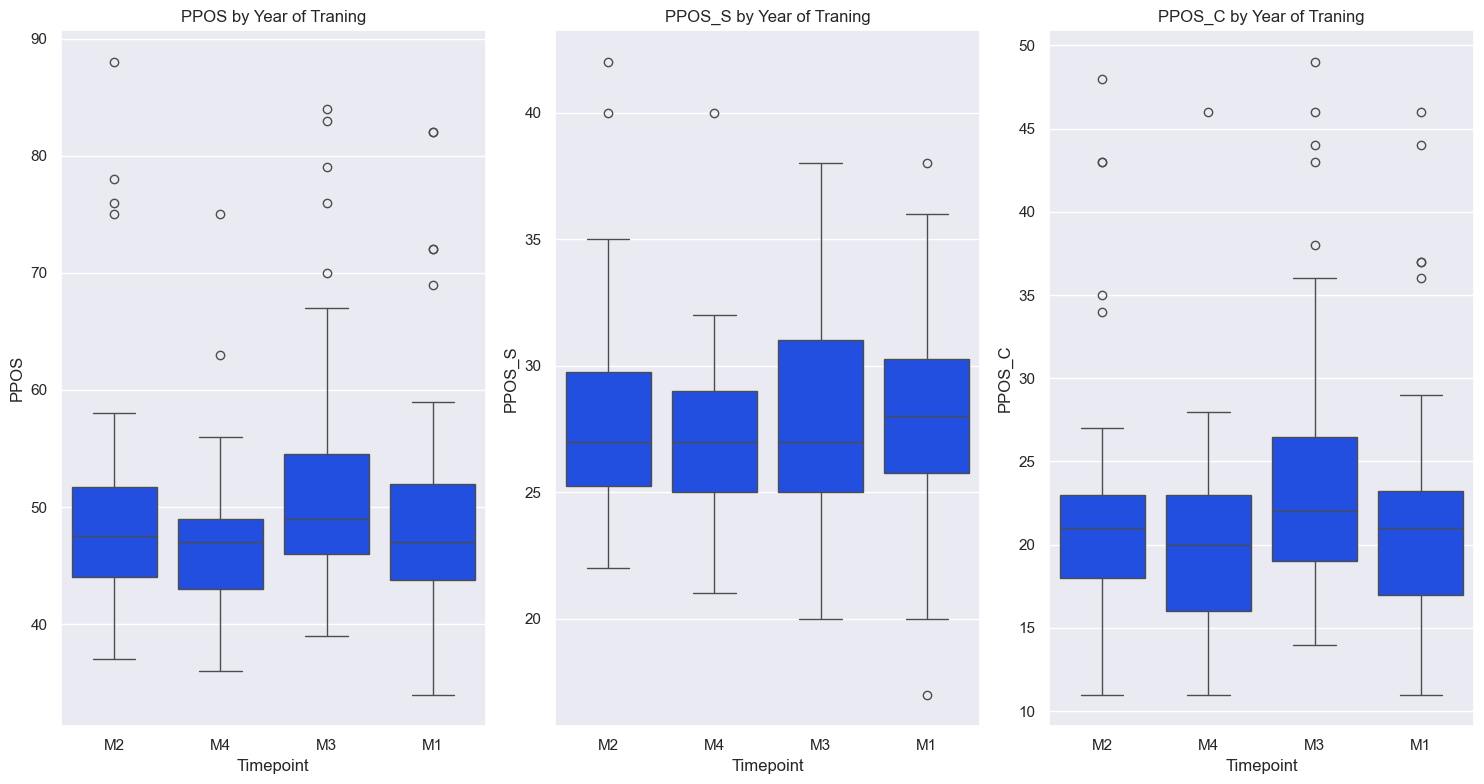

In [18]:
_, axes = plt.subplots(1,3, figsize=(15,8))

for col, ax in zip(score_cols, axes):
    sns.boxplot(data=df, x='timepoint', y=col, ax=ax)
    ax.set_title(f"{col.upper()} by Year of Traning")
    ax.set_xlabel("Timepoint")
    ax.set_ylabel(col.upper())
    
plt.tight_layout()
plt.show()

In [19]:
df.groupby('highest_degree')[score_cols].describe()

summary = df.groupby('highest_degree')[score_cols].describe()
summary = summary.round(2)
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
display(summary)

,ppos_count,ppos_mean,ppos_std,ppos_min,ppos_25%,ppos_50%,ppos_75%,ppos_max,ppos_s_count,ppos_s_mean,...,ppos_s_75%,ppos_s_max,ppos_c_count,ppos_c_mean,ppos_c_std,ppos_c_min,ppos_c_25%,ppos_c_50%,ppos_c_75%,ppos_c_max
highest_degree,,,,,,,,,,,,,,,,,,,,,
Bachelors,48.0,49.19,9.27,35.0,43.75,47.5,52.00,78.0,48.0,27.77,...,29.25,40.0,48.0,21.42,6.78,11.0,17.75,20.5,23.00,43.0
DEC/CEGEP,35.0,52.11,13.98,36.0,44.50,47.0,51.00,88.0,35.0,28.09,...,30.50,40.0,35.0,24.03,9.97,11.0,19.00,21.0,22.50,49.0
Doctorate,11.0,49.55,11.35,34.0,42.00,47.0,54.50,76.0,11.0,28.36,...,30.50,38.0,11.0,21.18,7.76,11.0,17.00,19.0,24.50,38.0
Masters,44.0,51.25,10.41,40.0,44.75,49.0,53.25,84.0,44.0,27.98,...,30.25,42.0,44.0,23.27,8.00,13.0,17.00,21.0,25.25,46.0


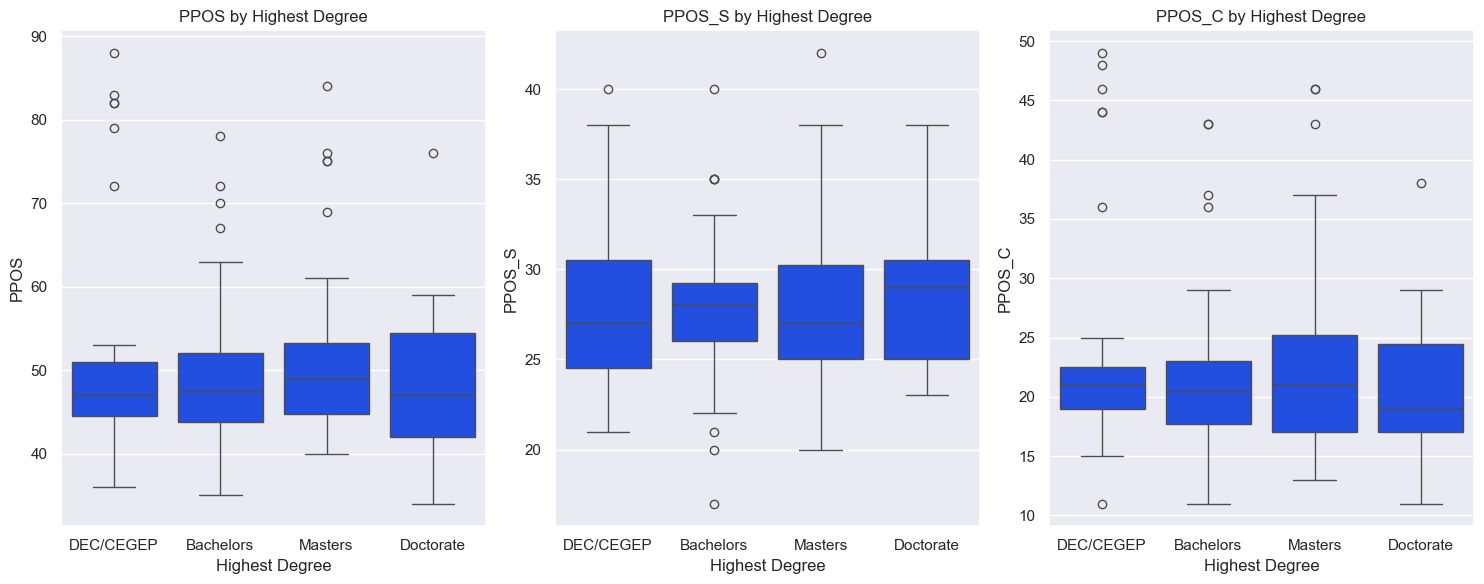

In [20]:
_, axes = plt.subplots(1,3, figsize=(15,6))

for col, ax in zip(score_cols, axes):
    sns.boxplot(data=df, x='highest_degree', y=col, order=['DEC/CEGEP', 'Bachelors', 'Masters', 'Doctorate'], ax=ax)
    ax.set_title(f"{col.upper()} by Highest Degree")
    ax.set_xlabel("Highest Degree")
    ax.set_ylabel(col.upper())

plt.tight_layout()
plt.show()

In [21]:
summary = df.groupby('gender')[score_cols].describe()
summary = summary.round(2)
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
display(summary)


,ppos_count,ppos_mean,ppos_std,ppos_min,ppos_25%,ppos_50%,ppos_75%,ppos_max,ppos_s_count,ppos_s_mean,...,ppos_s_75%,ppos_s_max,ppos_c_count,ppos_c_mean,ppos_c_std,ppos_c_min,ppos_c_25%,ppos_c_50%,ppos_c_75%,ppos_c_max
gender,,,,,,,,,,,,,,,,,,,,,
Female,90.0,50.09,11.38,34.0,43.0,47.0,52.00,88.0,90.0,27.82,...,30.0,40.0,90.0,22.27,8.38,11.0,17.00,20.5,23.75,49.0
Male,48.0,51.60,10.56,36.0,46.0,49.0,52.25,84.0,48.0,28.23,...,31.0,42.0,48.0,23.38,7.71,11.0,18.75,21.5,24.25,46.0


In [26]:
summary = df.groupby(['primary_care', 'non_primary_care'])[score_cols].describe()
summary = summary.round(2)
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
display(summary)

ppos_count  ppos_mean  ppos_std  ppos_min  \
primary_care non_primary_care                                              
False        False                   54.0      51.09     10.96      34.0   
             True                    61.0      51.31     12.34      35.0   
True         False                   23.0      47.65      7.08      39.0   

                               ppos_25%  ppos_50%  ppos_75%  ppos_max  \
primary_care non_primary_care                                           
False        False                 44.0      49.0     54.75      82.0   
             True                  45.0      48.0     52.00      88.0   
True         False                 42.0      47.0     50.50      70.0   

                               ppos_s_count  ppos_s_mean  ...  ppos_s_75%  \
primary_care non_primary_care                             ...               
False        False                     54.0        28.09  ...        30.0   
             True                      61.0        27.98  ...        31.0   
True         False                     23.0        27.61  ...        28.5   

                               ppos_s_max  ppos_c_count  ppos_c_mean  \
primary_care non_primary_care                                          
False        False                   38.0          54.0        23.00   
             True                    42.0          61.0        23.33   
True         False                   36.0          23.0        20.04   

                               ppos_c_std  ppos_c_min  ppos_c_25%  ppos_c_50%  \
primary_care non_primary_care                                                   
False        False                   8.54        11.0       17.25        21.0   
             True                    8.33        11.0       18.00        21.0   
True         False                   6.22        13.0       16.50        19.0   

                               ppos_c_75%  ppos_c_max  
primary_care non_primary_care                          
False        False                   24.0        46.0  
             True                    24.0        49.0  
True         False                   21.0        43.0  

[3 rows x 24 columns]

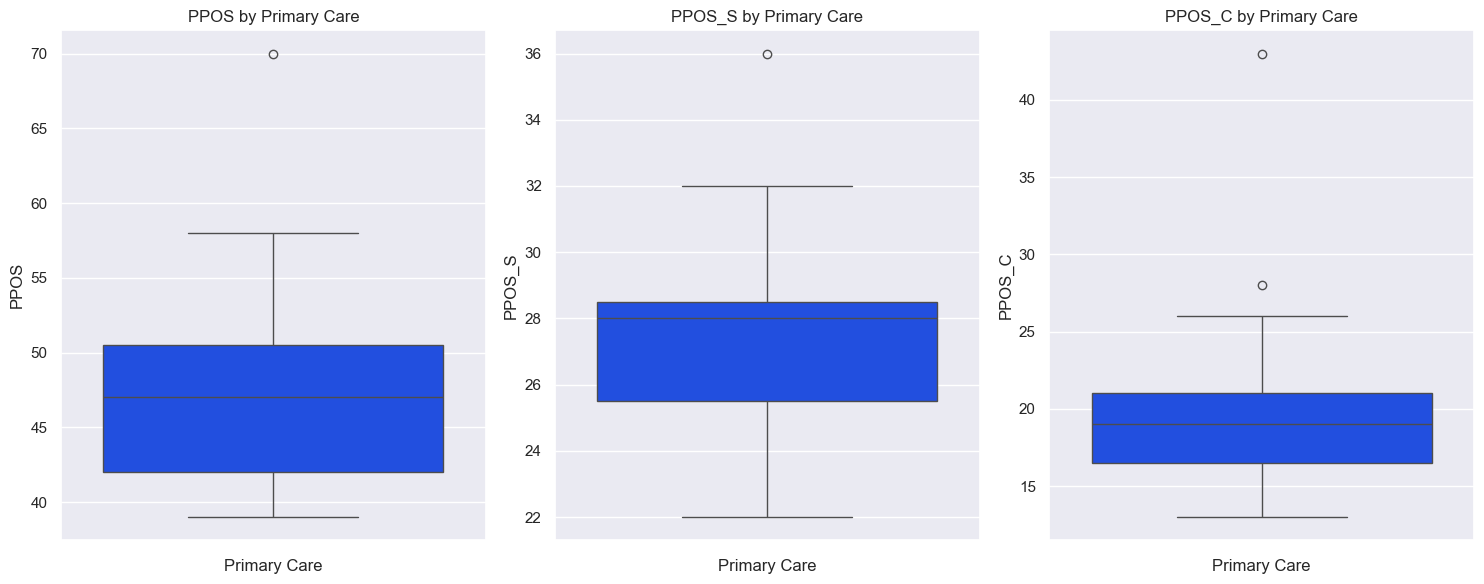

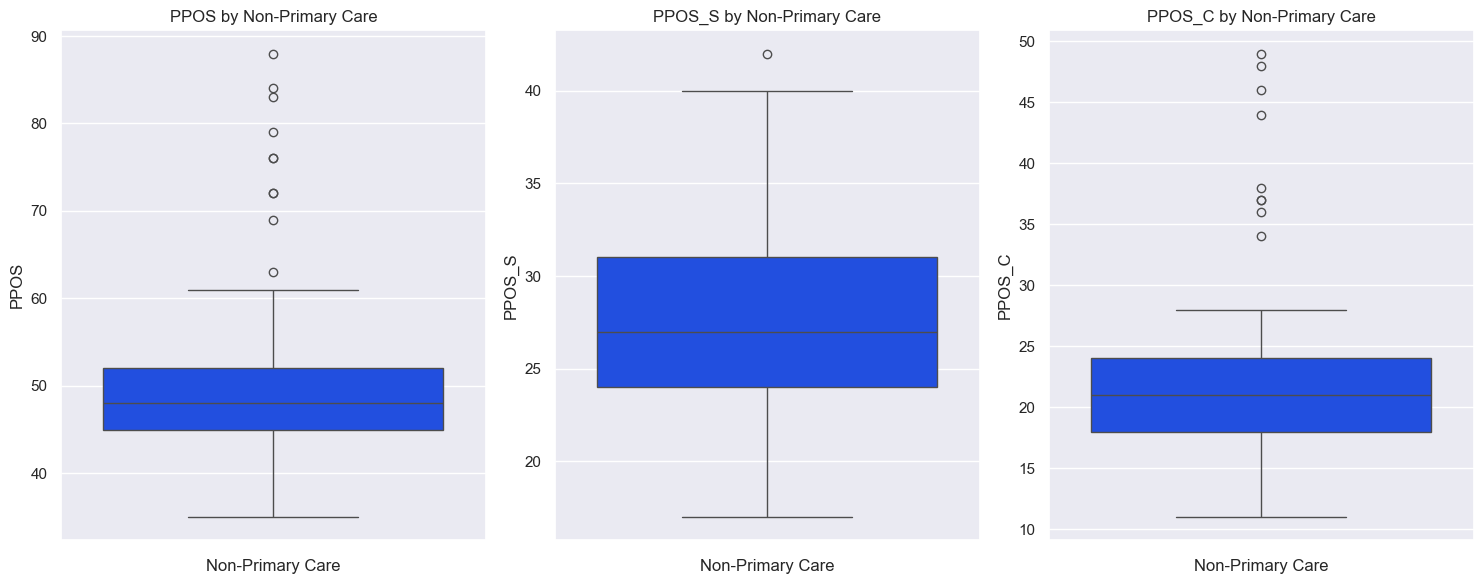

In [37]:
# Plot by primary_care
_, axes = plt.subplots(1, 3, figsize=(15, 6))
for col, ax in zip(score_cols, axes):
    sns.boxplot(y=df.loc[df['primary_care'], col], ax=ax)
    ax.set_title(f"{col.upper()} by Primary Care")
    ax.set_xlabel("Primary Care")
    ax.set_ylabel(col.upper())
plt.tight_layout()
plt.show()

# Plot by non_primary_care
_, axes = plt.subplots(1, 3, figsize=(15, 6))
for col, ax in zip(score_cols, axes):
    sns.boxplot(y=df.loc[df['non_primary_care'],col], ax=ax)
    ax.set_title(f"{col.upper()} by Non-Primary Care")
    ax.set_xlabel("Non-Primary Care")
    ax.set_ylabel(col.upper())
plt.tight_layout()
plt.show()

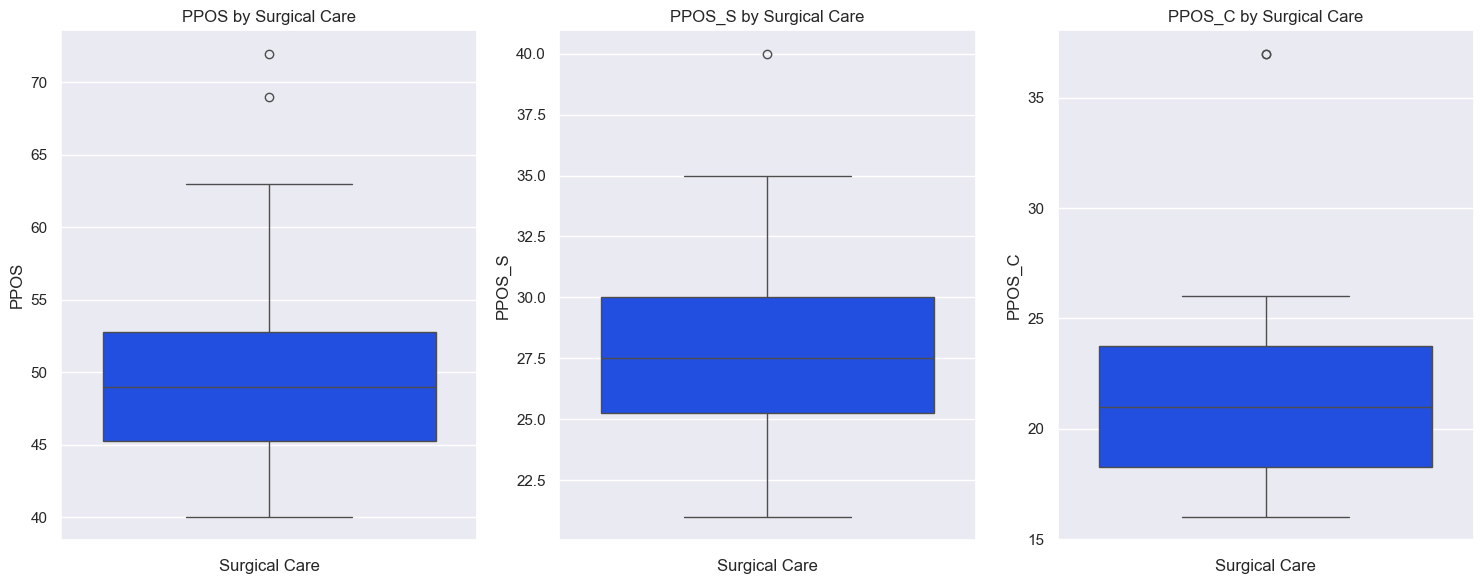

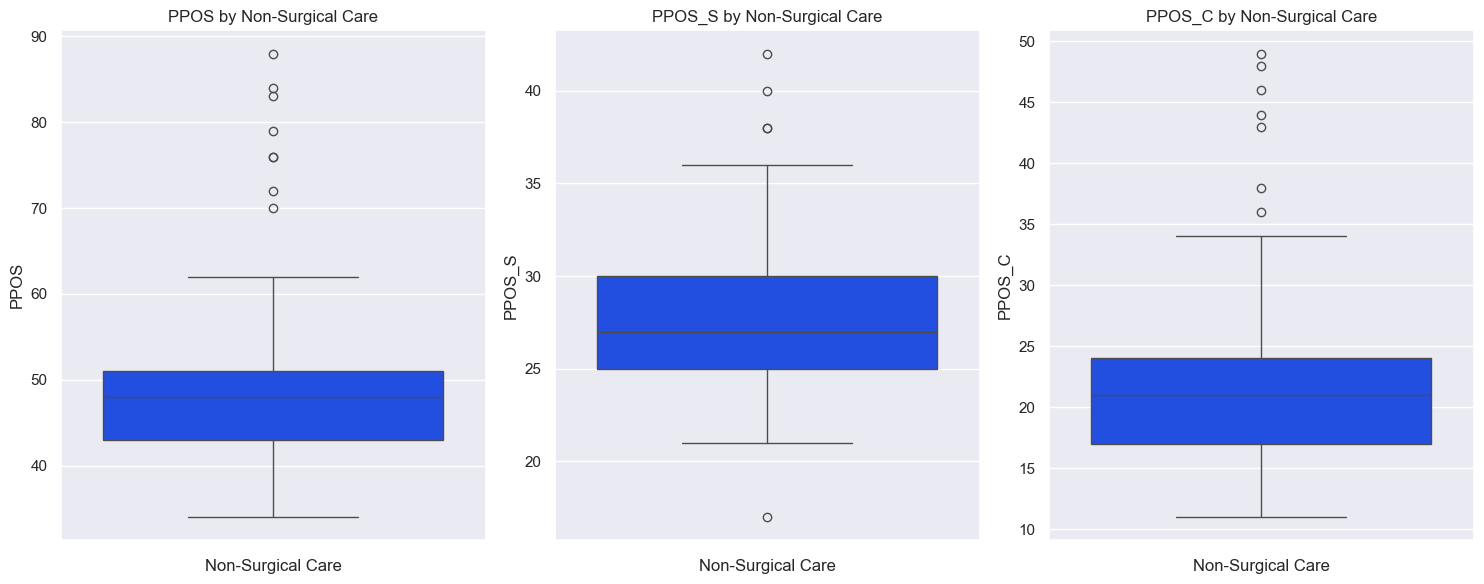

In [39]:
# Plot by primary_care
_, axes = plt.subplots(1, 3, figsize=(15, 6))
for col, ax in zip(score_cols, axes):
    sns.boxplot(y=df.loc[df['surgical'], col], ax=ax)
    ax.set_title(f"{col.upper()} by Surgical Care")
    ax.set_xlabel("Surgical Care")
    ax.set_ylabel(col.upper())
plt.tight_layout()
plt.show()

# Plot by non_primary_care
_, axes = plt.subplots(1, 3, figsize=(15, 6))
for col, ax in zip(score_cols, axes):
    sns.boxplot(y=df.loc[df['non_surgical'],col], ax=ax)
    ax.set_title(f"{col.upper()} by Non-Surgical Care")
    ax.set_xlabel("Non-Surgical Care")
    ax.set_ylabel(col.upper())
plt.tight_layout()
plt.show()

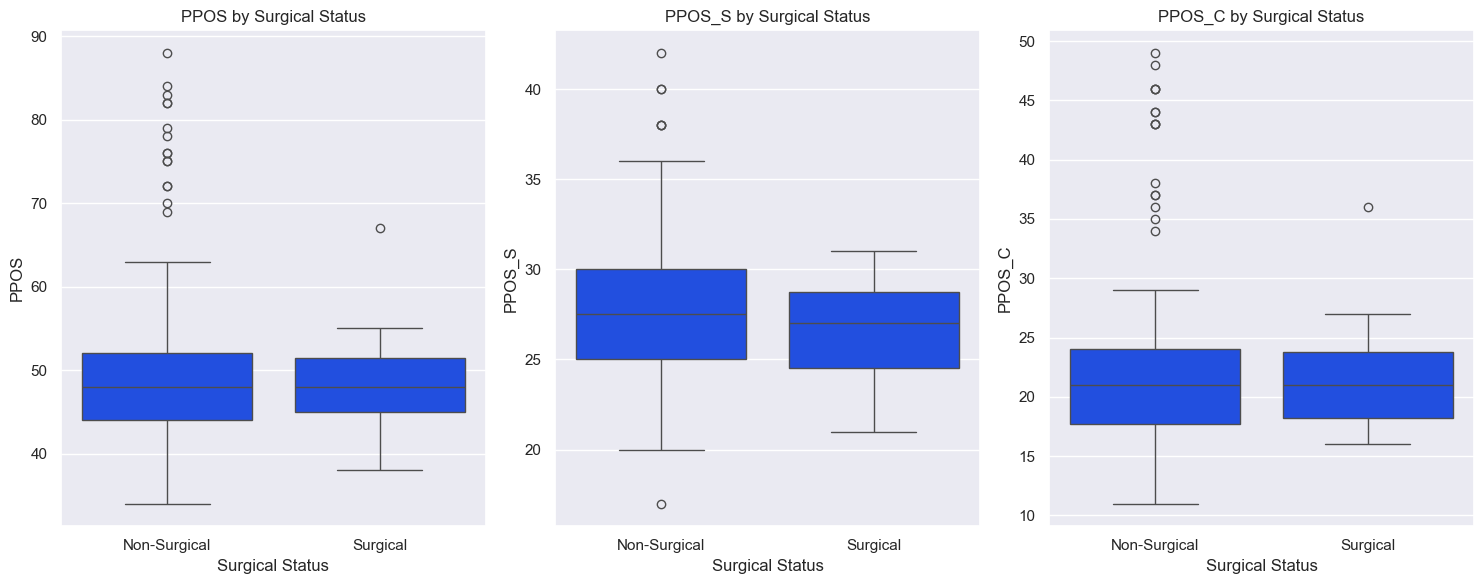

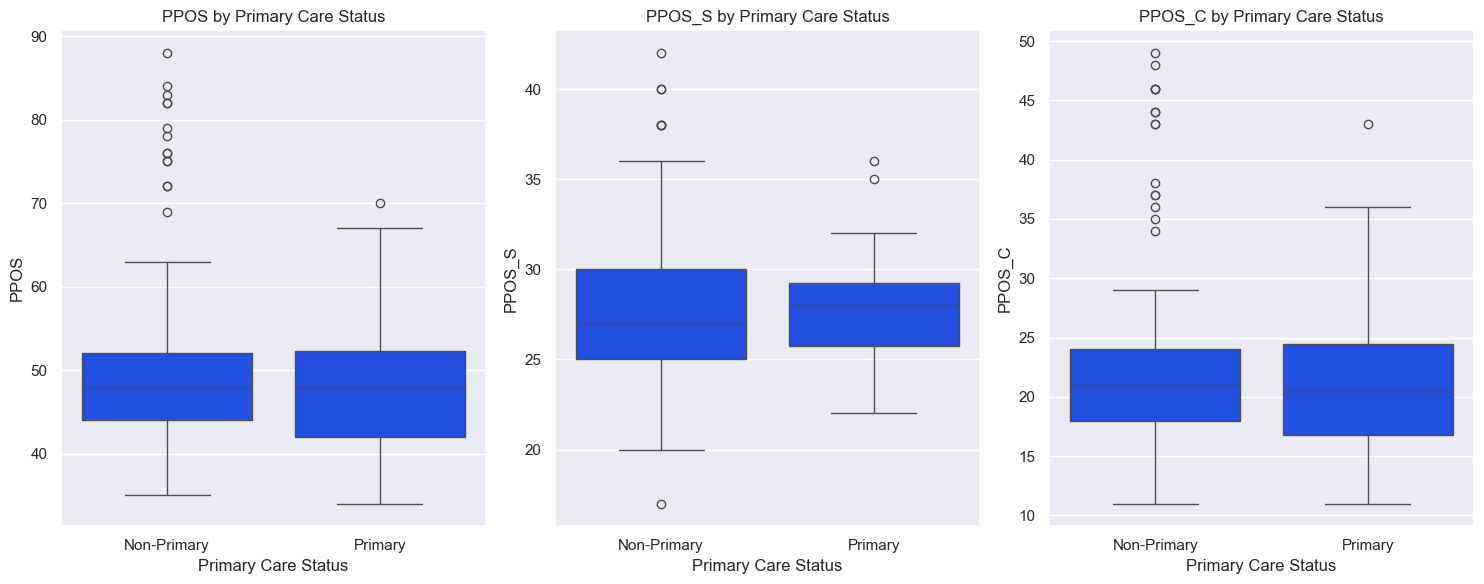

In [ ]:
# ...existing code...
_, axes = plt.subplots(1, 3, figsize=(15, 6))

df['surgical_status'] = df[primary]
for col, ax in zip(score_cols, axes):
    sns.boxplot(data=df, x='surgical', y=col, ax=ax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Non-Surgical', 'Surgical'])
    ax.set_title(f"{col.upper()} by Surgical Status")
    ax.set_xlabel("Surgical Status")
    ax.set_ylabel(col.upper())

plt.tight_layout()
plt.show()

_, axes = plt.subplots(1, 3, figsize=(15, 6))

for col, ax in zip(score_cols, axes):
    sns.boxplot(data=df, x='primary', y=col, ax=ax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Non-Primary', 'Primary'])
    ax.set_title(f"{col.upper()} by Primary Care Status")
    ax.set_xlabel("Primary Care Status")
    ax.set_ylabel(col.upper())

plt.tight_layout()
plt.show()
# ...existing code...

In [ ]:
df.to_excel(excel_writer="cleaned_data.xlsx", index=False)

Code for scollable tables
```html
div.output_scroll {
    overflow-x: auto;
    white-space: nowrap;
}
table {
    display: block;
    overflow-x: auto;
    white-space: nowrap;
}
```

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   record_id                 138 non-null    int64 
 1   timepoint                 138 non-null    object
 2   ppos                      138 non-null    int64 
 3   ppos_s                    138 non-null    int64 
 4   ppos_c                    138 non-null    int64 
 5   age                       138 non-null    int64 
 6   gender                    138 non-null    object
 7   cultural_black            138 non-null    bool  
 8   cultural_east_asian       138 non-null    bool  
 9   cultural_indigenous       138 non-null    bool  
 10  cultural_middle_eastern   138 non-null    bool  
 11  cultural_latin_american   138 non-null    bool  
 12  cultural_south_asian      138 non-null    bool  
 13  cultural_southeast_asian  138 non-null    bool  
 14  cultural_white            